# Visualize othello board with highlighted background

Input to the model: "int", doesn't contain middle pieces
For plotting and correct conversion to board visualization: "string", does mind middle pieces 

## Setup

In [1]:
import os
import pickle

import torch as t
from huggingface_hub import hf_hub_download
import einops

from circuits.dictionary_learning.dictionary import AutoEncoder, AutoEncoderNew, GatedAutoEncoder
from circuits.utils import (
    othello_hf_dataset_to_generator,
    get_model,
    get_submodule,
)

from feature_viz_othello_utils import (
    get_acts_IEs_VN,
    plot_lenses,
    plot_mean_metrics,
    plot_top_k_games
)

import circuits.utils as utils
import circuits.analysis as analysis

repo_dir = '/home/can/chess-gpt-circuits'
# repo_dir = "/home/adam/chess-gpt-circuits"
device = 'cuda:0'

In [2]:
# download data from huggingface if needed
if not os.path.exists(f'{repo_dir}/autoencoders/othello_5-21'):
    hf_hub_download(repo_id='adamkarvonen/othello_saes', filename='othello_5-21.zip', local_dir=f'{repo_dir}/autoencoders')
    # unzip the data
    os.system(f'unzip {repo_dir}/autoencoders/othello_5-21.zip -d autoencoders')

In [3]:
# load SAE
ae_type = 'p_anneal'
# ae_type = 'standard'
trainer_id = 4

ae_path = f'{repo_dir}/autoencoders/othello_5-21/othello-{ae_type}/trainer{trainer_id}'
if ae_type == 'standard' or ae_type == 'p_anneal':
    ae = AutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'gated' or ae_type == 'gated_anneal':
    ae = GatedAutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'standard_new':
    ae = AutoEncoderNew.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
else:
    raise ValueError('Invalid ae_type')

In [4]:
# load model and data
layer = 5
context_length = 59
activation_dim = 512  # output dimension of the layer
model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
dataset_name = "taufeeque/othellogpt"

model = get_model(model_name, device)
resid_submodule = model.blocks[layer].hook_resid_post
mlp_submodule = model.blocks[layer].mlp.hook_post
mlp_post_submodules = [model.blocks[l].mlp.hook_post for l in range(model.cfg.n_layers)]


data = othello_hf_dataset_to_generator(
    dataset_name, context_length=context_length, split="train", streaming=True
)

Loaded pretrained model Baidicoot/Othello-GPT-Transformer-Lens into HookedTransformer
Moving model to device:  cuda:0


Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
# M = Activation dimension
# S = Sequence length
# B = Batch size, ie games per batch
# L = Number of batches
# N = L * B = Total number of games

B = 10 # B
L = 2 # L

games_batch_LBS = [[next(data) for _ in range(B)] for _ in range(L)]
games_batch_LBS = t.tensor(games_batch_LBS, device=device)
print(f'game_batch shape: {games_batch_LBS.shape}')

game_batch shape: torch.Size([20, 2, 59])


In [6]:
# load feature analysis results
def to_device(d, device=device):
    if isinstance(d, t.Tensor):
        return d.to(device)
    if isinstance(d, dict):
        return {k: to_device(v, device) for k, v in d.items()}


with open (os.path.join(ae_path, 'indexing_None_n_inputs_1000_results.pkl'), 'rb') as f:
    results = pickle.load(f)

results = utils.to_device(results, device)

print(results.keys())

feature_labels, misc_stats = analysis.analyze_results_dict(results, "", device, save_results=False, verbose=False, print_results=False, significance_threshold=100)
print(feature_labels.keys())


with open (os.path.join(ae_path, 'n_inputs_1000_evals.pkl'), 'rb') as f:
    eval_results = pickle.load(f)
print(eval_results.keys())
print(f"L0: {eval_results['eval_results']['l0']}")

dict_keys(['on_count', 'off_count', 'alive_features', 'games_batch_to_state_stack_mine_yours_BLRRC', 'games_batch_to_state_stack_mine_yours_blank_mask_BLRRC', 'games_batch_to_valid_moves_BLRRC', 'hyperparameters', 'trainer_class', 'sae_class'])
dict_keys(['thresholds', 'alive_features', 'indexing_function', 'games_batch_to_state_stack_mine_yours_BLRRC', 'games_batch_to_state_stack_mine_yours_blank_mask_BLRRC', 'games_batch_to_valid_moves_BLRRC'])
dict_keys(['hyperparameters', 'eval_results'])
L0: 77.1500015258789


# Here's the interactive part

In [7]:
def find_alive_feature_idx(desired_feat_idx: int, feature_labels: dict) -> int:
    for idx, feat_idx in enumerate(feature_labels['alive_features']):
        if feat_idx == desired_feat_idx:
            print(f"Found feature index {desired_feat_idx} at index {idx}")
            return idx
    raise ValueError(f"Feature index {desired_feat_idx} not found in alive features")

alive_idx = find_alive_feature_idx(3098, feature_labels)
alive_idx = 18
show_indirect_effects = False
node_type = 'sae_feature'
# node_type = 'mlp_neuron' # ['sae_feature', 'mlp_neuron']

Found feature index 3098 at index 2681
Found feature index 1392 at index 1208


In [8]:
if node_type == 'sae_feature':
    node_idx = int(feature_labels['alive_features'][alive_idx])
    submodule = resid_submodule
    chosen_ae = ae
elif node_type == 'mlp_neuron':
    node_idx = alive_idx
    submodule = mlp_submodule
    chosen_ae = None
else:
    raise ValueError('Invalid node_type')

show_indirect_effects = True

t.cuda.empty_cache()
t.set_grad_enabled(False)

if show_indirect_effects:
    t.set_grad_enabled(True)

feature_acts_NS, acts_per_tokenembed_VN, ie_feature_to_logits_VN, ie_tokenembed_to_features_VN = get_acts_IEs_VN(
    model, chosen_ae, games_batch_LBS, submodule, feat_idx=node_idx, compute_ie=show_indirect_effects, device=device
)

print(f'feat_idx: {node_idx}')
print(f'games_batch shape: {games_batch_LBS.shape}')
print(f'feature_acts shape: {feature_acts_NS.shape}')

Games batch: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

feat_idx: 21
games_batch shape: torch.Size([20, 2, 59])
feature_acts shape: torch.Size([40, 59])


## Weight space
Cosine sim of feature decoder vector with 
- token_embed
- unembed

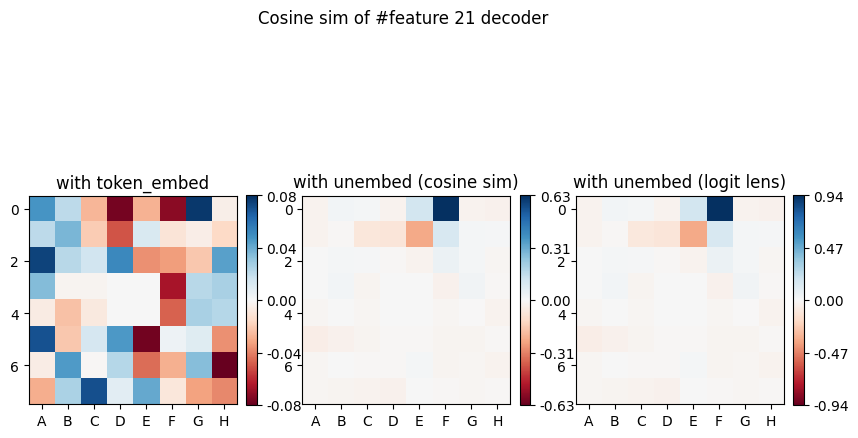

In [9]:
import importlib
import feature_viz_othello_utils
importlib.reload(feature_viz_othello_utils) 
feature_viz_othello_utils.plot_lenses(model, ae, node_idx, device, node_type)

## Activation space

1. Feature act per input_token
2. IE input_token --> feature
3. IE feature --> logit

- mean over N games
- topK over N games

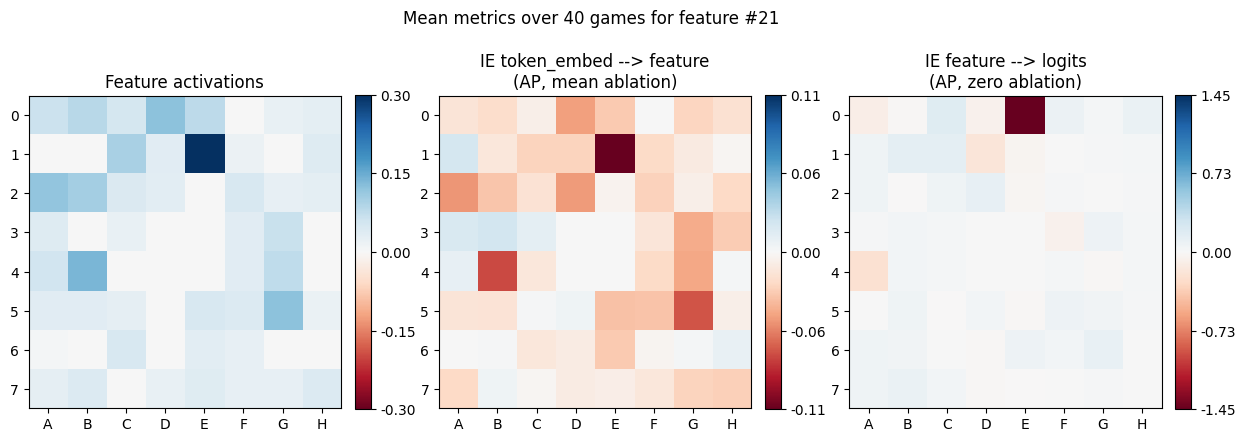

In [10]:
plot_mean_metrics(
    acts_per_tokenembed_VN, ie_tokenembed_to_features_VN, ie_feature_to_logits_VN, 
    node_idx, n_games=B*L, device=device, with_ie=show_indirect_effects
    )

torch.Size([61, 40])
Top 1 activation game:


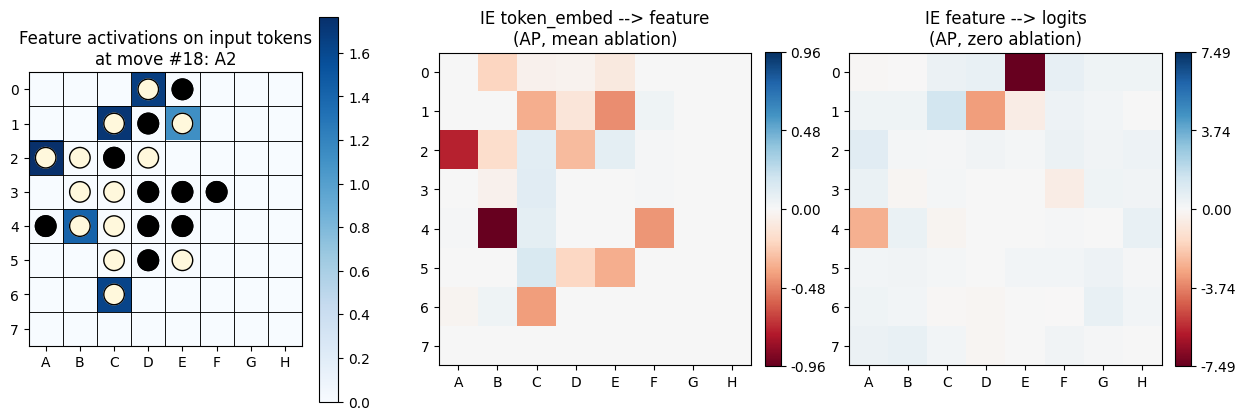

Top 2 activation game:


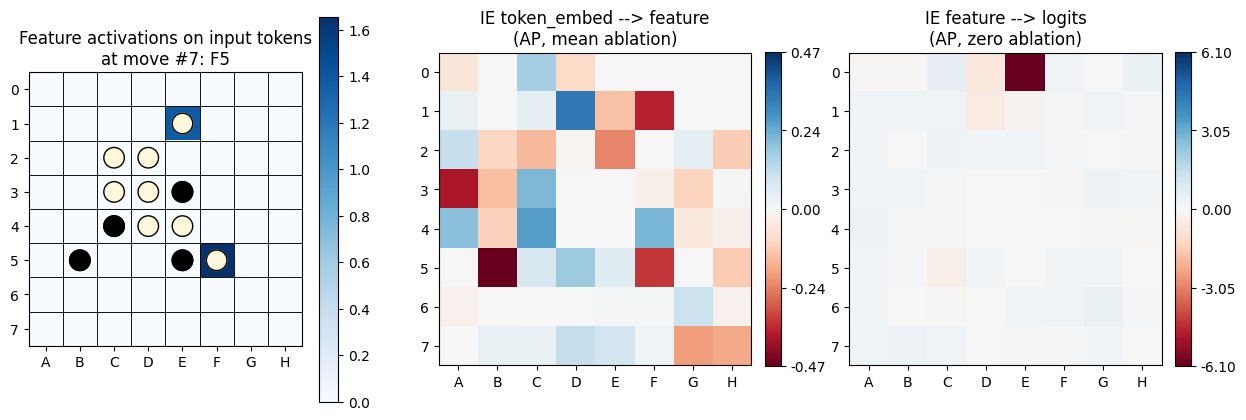

Top 3 activation game:


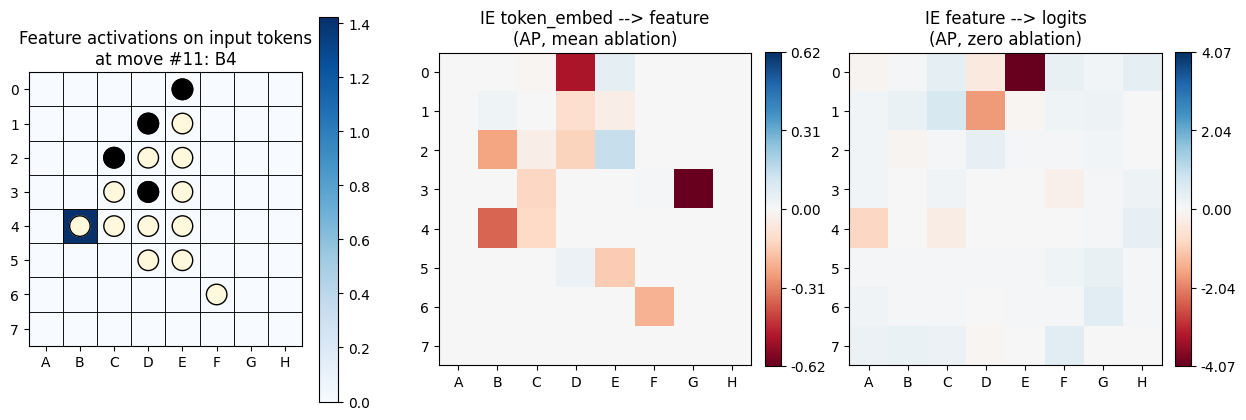

Top 4 activation game:


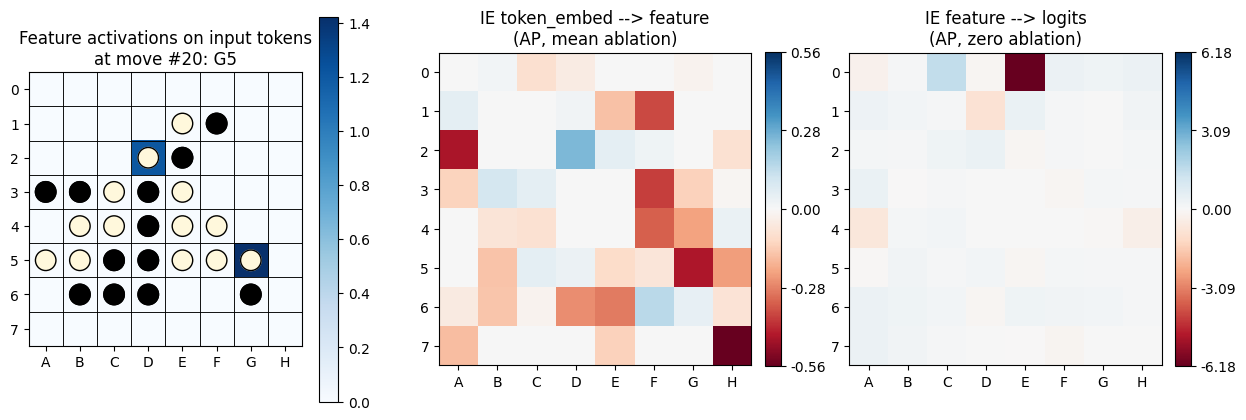

Top 5 activation game:


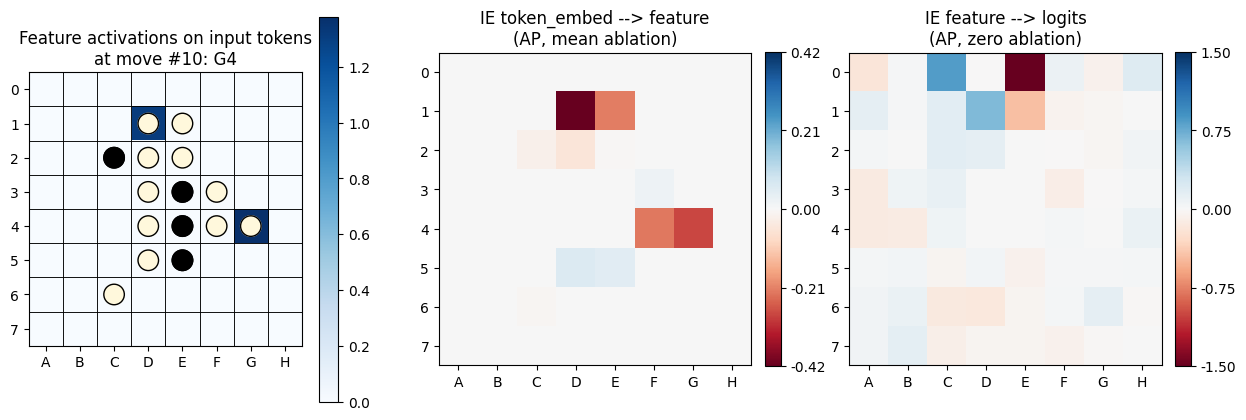

Top 6 activation game:


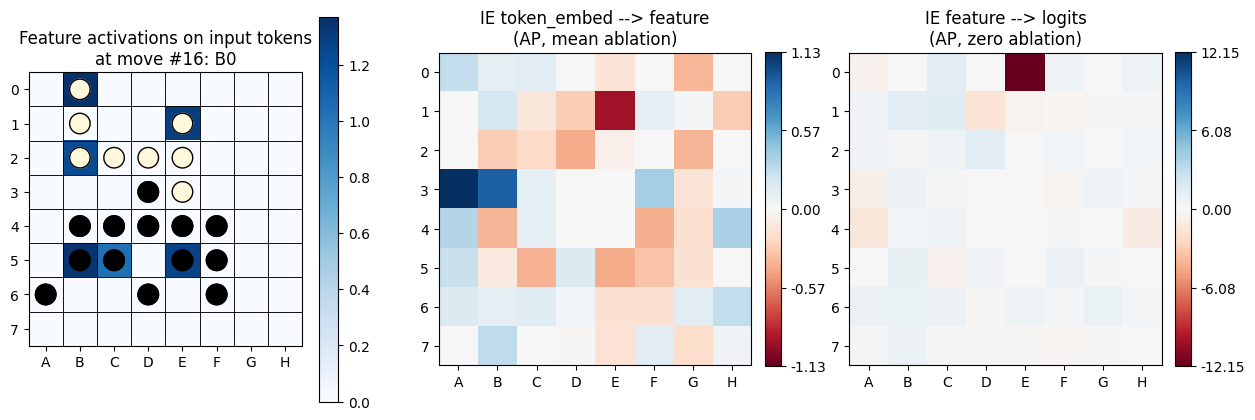

Top 7 activation game:


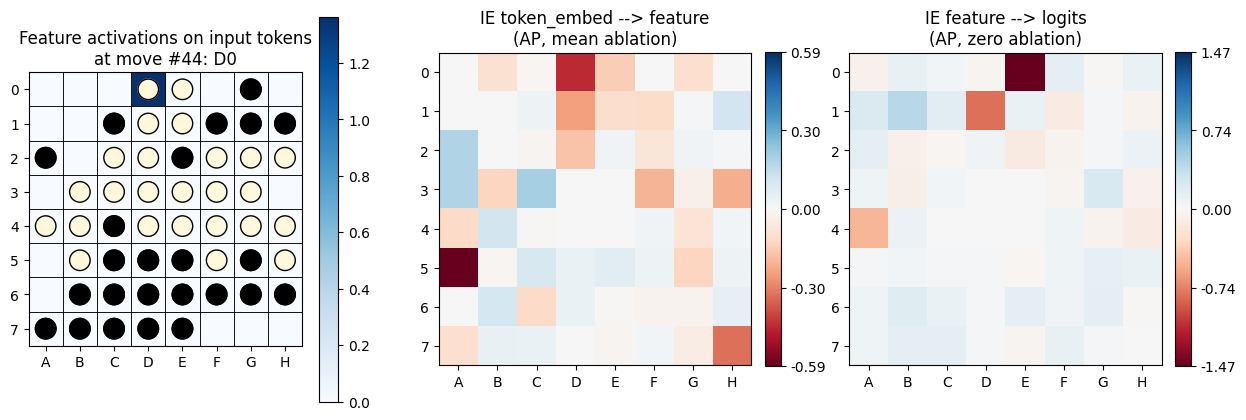

Top 8 activation game:


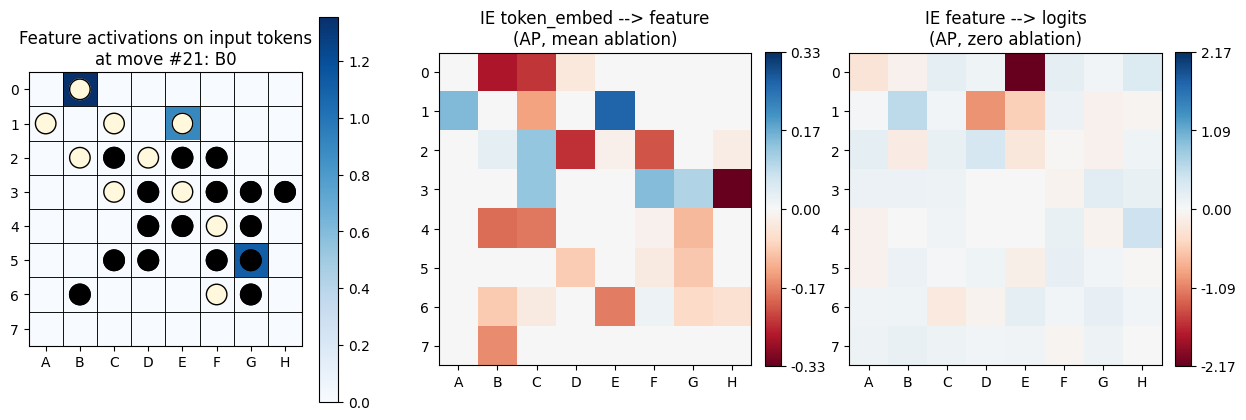

Top 9 activation game:


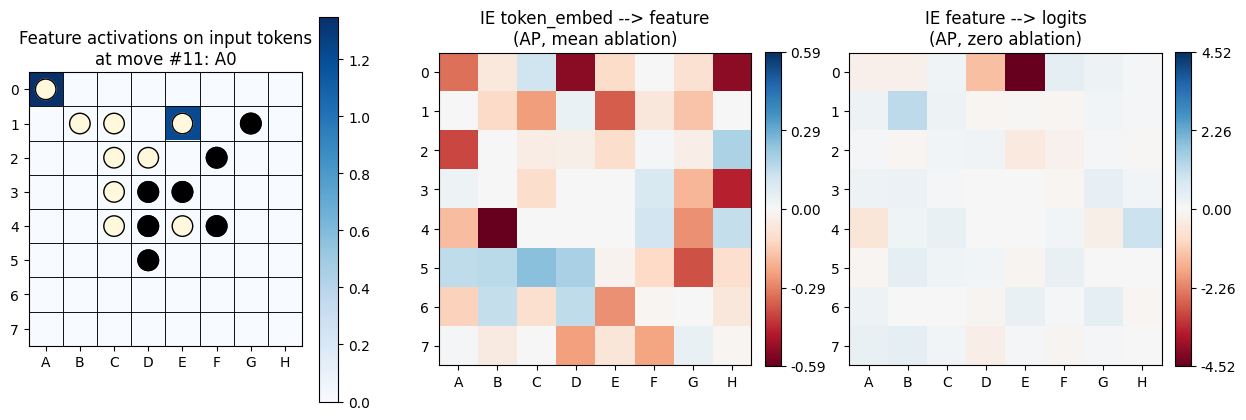

Top 10 activation game:


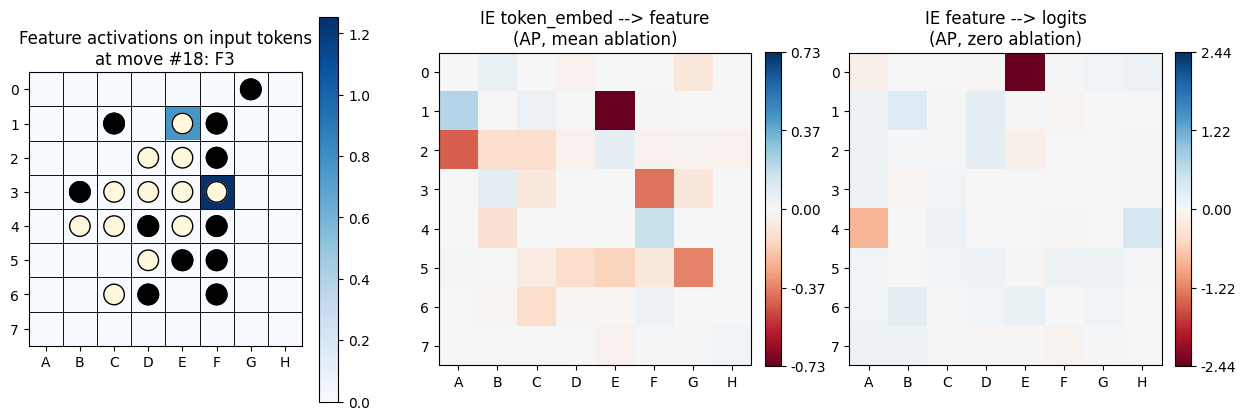

In [11]:
# Choose metric to retrieve top k games
k = 10
sort_metric = 'activation' # ['activation', 'ie_embed','ie_logit']

games_batch_NS = games_batch_LBS.view(-1, context_length)

plot_top_k_games(
    node_idx,
    games_batch_NS,
    feature_acts_NS,
    acts_per_tokenembed_VN,
    ie_tokenembed_to_features_VN,
    ie_feature_to_logits_VN,
    sort_metric=sort_metric,
    k=k,
    with_ie=show_indirect_effects,
    device=device,
)

## Board reconstruction: lookup table for high precision classifiers

In [12]:
board_state_function = 'games_batch_to_state_stack_mine_yours_BLRRC'
board_state_function = 'games_batch_to_state_stack_mine_yours_blank_mask_BLRRC'
# board_state_function = 'games_batch_to_valid_moves_BLRRC'

# There's 11 thresholds in the lookup table. If 0, the lookup table is constructed from every activation
# If 1, it's constructed from all activations above 10% of that feature's max activation. If 2, 20% etc.
# 1 is a reasonable default
threshold_idx = 5

demo_idx = None

squares_classified_counts = []
for alive_feature_index in range(len(feature_labels['alive_features'])):
    num_classified_squares = feature_labels[board_state_function][threshold_idx][alive_feature_index].sum()
    if num_classified_squares > 0:
        print(f'Feature {alive_feature_index} has {num_classified_squares} classified squares')
        squares_classified_counts.append(num_classified_squares.item())

        demo_idx = alive_feature_index

if demo_idx is None:
    raise ValueError('No features have any classified squares')

Feature 1 has 1 classified squares
Feature 2 has 2 classified squares
Feature 4 has 2 classified squares
Feature 8 has 1 classified squares
Feature 18 has 2 classified squares
Feature 21 has 1 classified squares
Feature 23 has 1 classified squares
Feature 24 has 3 classified squares
Feature 29 has 2 classified squares
Feature 30 has 5 classified squares
Feature 32 has 2 classified squares
Feature 34 has 1 classified squares
Feature 36 has 3 classified squares
Feature 38 has 2 classified squares
Feature 39 has 1 classified squares
Feature 45 has 3 classified squares
Feature 46 has 2 classified squares
Feature 48 has 2 classified squares
Feature 49 has 1 classified squares
Feature 50 has 2 classified squares
Feature 51 has 2 classified squares
Feature 52 has 1 classified squares
Feature 53 has 2 classified squares
Feature 54 has 5 classified squares
Feature 57 has 2 classified squares
Feature 58 has 1 classified squares
Feature 61 has 1 classified squares
Feature 62 has 2 classified squa

[1, 2, 2, 1, 2, 1, 1, 3, 2, 5, 2, 1, 3, 2, 1, 3, 2, 2, 1, 2, 2, 1, 2, 5, 2, 1, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1, 3, 2, 6, 3, 3, 3, 3, 2, 3, 2, 3, 1, 1, 1, 1, 2, 6, 1, 3, 3, 1, 1, 4, 1, 5, 4, 1, 3, 4, 3, 2, 2, 3, 1, 3, 1, 2, 1, 4, 3, 1, 2, 1, 1, 3, 2, 1, 3, 2, 2, 1, 1, 2, 3, 6, 1, 2, 3, 2, 2, 1, 3, 3, 1, 2, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 3, 2, 1, 3, 3, 1, 4, 3, 2, 4, 3, 2, 1, 3, 1, 1, 2, 2, 1, 2, 1, 1, 2, 4, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 4, 3, 3, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 3, 3, 1, 3, 2, 1, 4, 2, 1, 1, 3, 1, 1, 3, 2, 2, 1, 1, 3, 1, 1, 1, 3, 2, 4, 2, 1, 3, 2, 2, 1, 3, 1, 2, 2, 1, 1, 1, 3, 1, 1, 4, 2, 2, 3, 1, 1, 3, 2, 2, 2, 1, 3, 3, 2, 3, 1, 2, 2, 2, 1, 1, 2, 1, 1, 4, 1, 2, 1, 4, 2, 3, 1, 3, 1, 2, 1, 1, 1, 5, 2, 1, 3, 6, 3, 3, 3, 1, 4, 1, 1, 3, 2, 2, 2, 1, 2, 3, 3, 3, 1, 2, 3, 3, 1, 2, 2, 2, 2, 2, 4, 2, 1, 1, 3, 1, 1, 1, 2, 1, 2, 3, 4, 2, 2, 3, 3, 3, 4, 1, 2, 1, 2, 2, 3, 1, 1, 2, 2, 3, 2, 2, 1, 3, 2, 3, 1, 2, 2, 3, 2, 2, 1, 3, 1, 3, 3, 2, 2, 1, 2, 3, 1, 

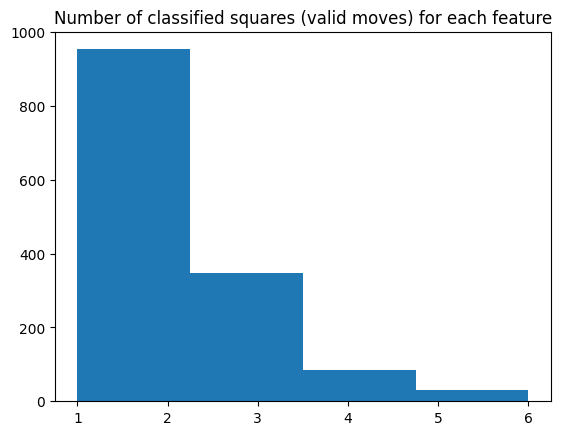

In [13]:
print(squares_classified_counts)
import matplotlib.pyplot as plt

# add title
plt.title(f'Number of classified squares (valid moves) for each feature')
plt.hist(squares_classified_counts, bins=4)
plt.savefig('classified_squares_hist_valid_moves.png')

In [14]:
node_idx = alive_idx
print(f'feat_idx: {node_idx}')

feat_idx: 18


In [15]:
threshold_idx = 1
print("Board states that the feature classifies according to Adam's measurements:")
print((feature_labels[board_state_function][threshold_idx][node_idx] == 1).nonzero())
print("Number of such board states:")
print((feature_labels[board_state_function][threshold_idx][node_idx] == 1).sum())

Board states that the feature classifies according to Adam's measurements:
tensor([[1, 4, 2],
        [2, 3, 2]], device='cuda:0')
Number of such board states:
tensor(2, device='cuda:0')


In [16]:
import numpy as np
import matplotlib.pyplot as plt

NOT_CLASSIFIED_VALUE = -9

def get_feature_label_classified_squares(feature_labels, board_state_function, threshold_idx, feature_idx) -> t.Tensor:
    sae_feature_board_state_RRC = feature_labels[board_state_function][threshold_idx][feature_idx]
    sae_feature_board_state_RR = t.argmax(sae_feature_board_state_RRC, dim=-1)
    sae_feature_board_state_RR -= 1

    zero_positions_RR = t.all(sae_feature_board_state_RRC == 0, dim=-1)
    sae_feature_board_state_RR[zero_positions_RR] = NOT_CLASSIFIED_VALUE
    return sae_feature_board_state_RR

def plot_board_categorical(board, feat_idx, board_state_function):
    # Define color map
    color_map = {-1: 'black', 0: 'grey', 1: 'white', NOT_CLASSIFIED_VALUE: 'yellow', -3: 'red'}
    unique_labels = np.unique(board)
    colors = [color_map[label] for label in unique_labels]
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    # Initialize plot
    fig, ax = plt.subplots()
    board_indices = np.vectorize(lambda x: np.where(unique_labels == x)[0][0])(board.numpy())
    cax = ax.imshow(board_indices, cmap=cmap)

    # Create a color bar with the correct labels
    cbar = fig.colorbar(cax, ticks=range(len(unique_labels)))
    cbar.ax.set_yticklabels([color_map[label] for label in unique_labels])

    # Plot labeling
    ax.set_xticks(range(8))
    ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
    ax.set_title(f'Feature #{feat_idx} is high precision classifier for:\n{board_state_function}\nGrey = Empty, Yellow = Not present in one hot vector')

    plt.show()

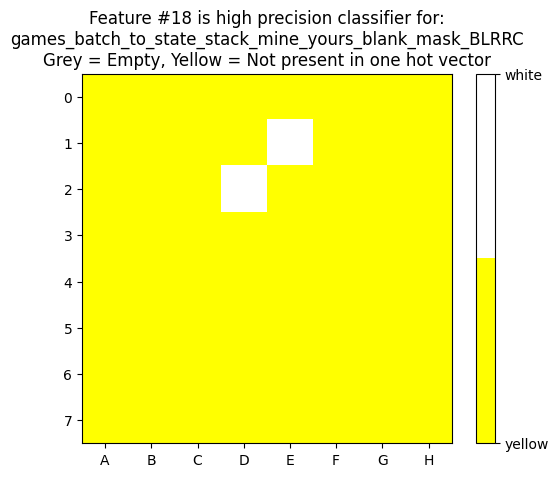

In [17]:
sae_feature_board_state_RR = get_feature_label_classified_squares(feature_labels, board_state_function, threshold_idx, node_idx)
plot_board_categorical(sae_feature_board_state_RR.to('cpu'), node_idx, board_state_function)